In [1]:
import time
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

Using TensorFlow backend.


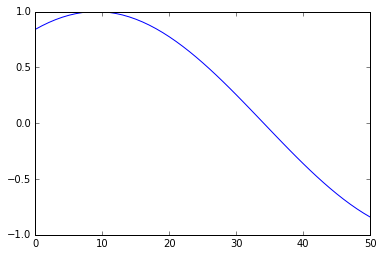

In [2]:
f = open("sinwave.csv", 'rb').read()
data = f.decode().split('\n')

seq_len = 50
# try changing this and seeing its affect on end result
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
    # here, index: is not a keyword, but the list data is being sliced from index to index + sequence_length
    
result = np.array(result)
# result is a list of 4950 lists where each sublist is a list of the datapoints in that particular 51 datapoint window
# this shape is 4950 x 51

t = np.linspace(0, 50, 51)
plt.plot(t, result[0])
plt.show()
plt.close()

row = round(0.9 * result.shape[0])
# to split the data set into train and test
# try changing this and seeing its affect on end result

train = result[:int(row), :]
# train is 4455 x 51
np.random.shuffle(train)
# try commenting this and seeing its affect on end result
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]

# x_train.shape = (4455, 50), and x_test.shape = (495, 50)
# Adding an extra dimension as Keras LSTM layers take in a NumPy array of 3 dimensions: (4455, 50) --> (4455, 50, 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [3]:
def build_model(layers):
    # here layers is a list with 4 elements
    
    model = Sequential()
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences = False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim = layers[3]))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    # try changing whether there is dropout, activation function, loss function, number of layers, in/out of layers
    
    return model

In [4]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
/home/arjung2/.local/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4232 samples, validate on 223 samples
Epoch 1/10
4232/4232 [==============================] - 5s 1ms/step - loss: 0.1896 - val_loss: 0.0260
Epoch 2/10
4232/4232 [==============================] - 2s 464us/step - loss: 0.0279 - val_loss: 0.0027
Epoch 3/10
4232/4232 [==============================] - 2s 480us/step - loss: 0.0196 - val_loss: 0.0080
Epoch 4/10
4232/4232 [==============================] - 2s 480us/step - loss: 0.0112 - val_loss: 0.0091
Epoch 5/10
4232/4232 [==============================] - 2s 501us/step - loss: 0.0117 - val_loss: 0.0104
Epoch 6/10
4232/4232 [==============================] - 2s 490us/step - loss: 0.0118 - val_loss: 0.0062
Epoch 7/10
4232/4232 [==============================] - 2s 473us/step - loss: 0.0101 - val_loss: 0.0155
Epoch 8/10
4232/4232 [==============================] - 2s 473us/step - loss: 0.0095 - val_loss: 0.0035
Epoch 9/10
4232/4232 [==============================] - 2s 453us/step - loss: 0.0109 - val_loss: 0.0032
Epoch 10/10
4232/42

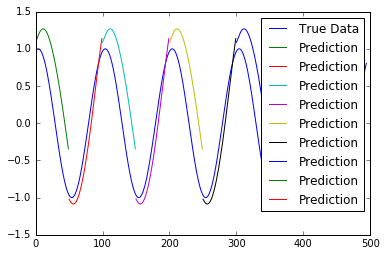

In [5]:
epochs = 10
global_start_time = time.time()

model = build_model([1, 50, 100, 1])

model.fit(x_train,
          y_train,
          batch_size=512,
          nb_epoch=epochs,
          validation_split=0.05)

predictions = predict_sequences_multiple(model, x_test, seq_len, 50)

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 50)